In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import levenberg_marquardt
from matplotlib.pyplot import figure
import heston
from importlib import reload
reload(heston)
from heston import calibrate_heston
import datetime
import matplotlib.dates as mdates
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv(f"../datasets/deribit_options_chain_2022-12-01_OPTIONS.csv")
df = df.drop(columns = ["exchange", "open_interest", 
                    "last_price", "bid_price", "bid_amount", "bid_iv",
                           "ask_price", "ask_amount", "ask_iv", "underlying_index",
                           "delta", "gamma", "vega", "theta" ,"rho"])
currency = "ETH"
ind = [symbol.startswith(currency) for symbol in df.symbol]
df = df[ind].reset_index(drop=True)

In [6]:
df.head()

,symbol,timestamp,local_timestamp,type,strike_price,expiration,mark_price,mark_iv,underlying_price
0,ETH-9DEC22-1400-C,1669852800002000,1669852800011631,call,1400,1670572800000000,0.0146,69.75,1294.5900
1,ETH-16DEC22-1300-P,1669852800011000,1669852800014218,put,1300,1671177600000000,0.0632,74.51,1294.5233
2,ETH-16DEC22-1500-C,1669852800010000,1669852800017777,call,1500,1671177600000000,0.0140,73.44,1294.5233
3,ETH-30DEC22-1400-P,1669852800013000,1669852800018794,put,1400,1672387200000000,0.1325,72.78,1294.2700
4,ETH-2DEC22-1300-C,1669852800013000,1669852800019006,call,1300,1669968000000000,0.0147,69.18,1294.4500


In [68]:
# calibrate base
number_of_dots = 500
kappas, nu_bars, sigmas, rhos, nu0s, errors = [], [], [], [], [], []
a = np.float64(3.0)  # kappa                     |  mean reversion rate | kappa (Article) | kappa (Roland's)
b = np.float64(0.1)  # v_infinity                |  long term variance | nu_bar           | alpha_bar 
c = np.float64(0.25)  # sigma                    |  volatility of volatility | sigma      | mu
rho = np.float64(0.01)  # rho                    |  correlation between spot and vol |rho | rho
v0 = np.float64(0.08) # init variance            | initial variance | nu_0                | alpha_0
start_params = np.array([a, b, c, rho, v0])
print("Optimize first params with random start once")
calibrated_params, first_error = calibrate_heston(df = df, start_params = start_params)

# Get ticks with similar distnce from available data
timestamps = np.linspace(df.timestamp.min(), df.timestamp.max(), number_of_dots)
for timestamp in tqdm(timestamps):
    calibrated_params, error = calibrate_heston(df = df, start_params = calibrated_params, timestamp = timestamp)
    kappas.append(calibrated_params[0])
    nu_bars.append(calibrated_params[1])
    sigmas.append(calibrated_params[2])
    rhos.append(calibrated_params[3])
    nu0s.append(calibrated_params[4])
    errors.append(error)
    
timestamps_hm = [datetime.datetime.fromtimestamp(x/1000000.0) for x in timestamps]

Optimize first params with random start once


  0%|          | 0/500 [00:00<?, ?it/s]

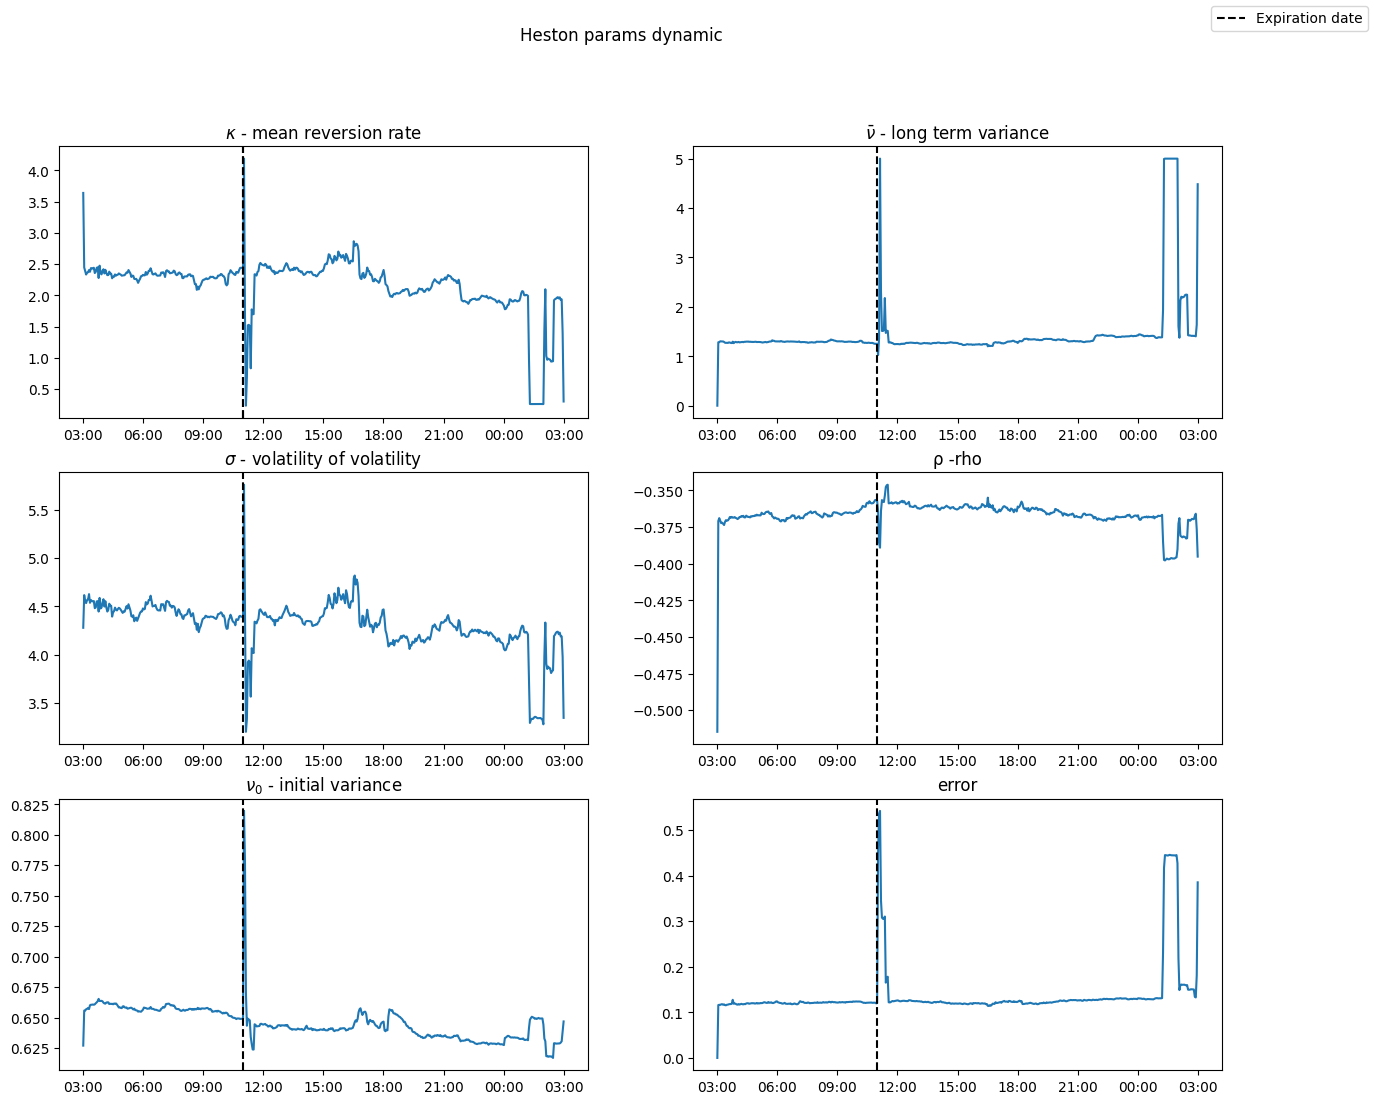

In [69]:
fig, axs =  plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
exp = datetime.datetime(2022, 12, 1, 11, 0, 0, 0 )


axs[0, 0].plot(timestamps_hm, kappas)
axs[0, 0].set_title(r"$\kappa$ - mean reversion rate")

axs[0, 1].plot(timestamps_hm, nu_bars)
axs[0, 1].set_title(r"$\bar{\nu}$ - long term variance")

axs[1, 0].plot(timestamps_hm, sigmas)
axs[1, 0].set_title(r"$\sigma$ - volatility of volatility")

axs[1, 1].plot(timestamps_hm, rhos)
axs[1, 1].set_title("ρ -rho")

axs[2, 0].plot(timestamps_hm, nu0s)
axs[2, 0].set_title(r"$\nu_0$ - initial variance")

axs[2, 1].plot(timestamps_hm, errors)
axs[2, 1].set_title("error")



for i in range(3):
    for j in range(2):
        axs[i, j].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        axs[i, j].axvline(x=exp, color = "black", linestyle  = "--")
        if i == j == 0:
            axs[i, j].axvline(x=exp, color = "black", linestyle  = "--", label = "Expiration date")


plt.figlegend() 
fig.suptitle("Heston params dynamic")

plt.show()